In [3]:
import sys
sys.path.insert(0, '..')

In [4]:
from scipy.io import loadmat
from os.path import basename
import numpy as np
from scipy import ndimage

In [14]:
import nibabel

In [17]:
heart = nibabel.load(r"C:\TudoCD\OpenDataset2\A0S9V9\A0S9V9_sa_gt.nii.gz").get_fdata()

In [18]:
heart.shape

(216, 256, 13, 25)

In [234]:
def get_slice_label(heart4d):
    heart = heart4d.copy()
    curve3 = np.sum(heart==3, axis=(0, 1, 3))
    curve2 = np.sum(heart==2, axis=(0, 1, 3))
    curve1 = np.sum(heart==1, axis=(0, 1, 3))

    curve_and = (curve3 > 0) & (curve2 > 0) & (curve1 > 0)
    curve_or = (curve3 > 0) | (curve2 > 0) | (curve1 > 0)
    curve_and = curve_and.astype(np.int)
    curve_or = curve_or.astype(np.int)
    curve_diff = curve_or-curve_and
    slice_label = curve_and * 0
    curve_apex = curve_diff.copy()
    curve_apex[:curve_apex.size//2] = 0
    curve_basal = curve_diff.copy()
    curve_basal[curve_apex.size//2:] = 0
    #curve_apex = curve_apex * 4
    
    loc = dict()
    if np.sum(curve_apex) > 0:
        #got_apex = True    
        loc[3] = [1]*1 + [2]*1 + [3]*1
        loc[4] = [1]*1 + [2]*2 + [3]*1
        loc[5] = [1]*2 + [2]*2 + [3]*1
        loc[6] = [1]*2 + [2]*2 + [3]*2
        loc[7] = [1]*2 + [2]*3 + [3]*2
        loc[8] = [1]*3 + [2]*3 + [3]*2
        loc[9] = [1]*3 + [2]*3 + [3]*3
        loc[10] = [1]*3 + [2]*4 + [3]*3
        loc[11] = [1]*4 + [2]*4 + [3]*3
        loc[12] = [1]*4 + [2]*4 + [3]*4
        loc[13] = [1]*4 + [2]*5 + [3]*4
        loc[14] = [1]*5 + [2]*5 + [3]*4
        loc[15] = [1]*5 + [2]*5 + [3]*5
    else:
        loc[3] = [1]*1 + [2]*1 + [3]*1
        loc[4] = [1]*1 + [2]*1 + [3]*1 + [4]*1
        loc[5] = [1]*1 + [2]*2 + [3]*1 + [4]*1
        loc[6] = [1]*2 + [2]*2 + [3]*1 + [4]*1
        loc[7] = [1]*2 + [2]*2 + [3]*2 + [4]*1
        loc[8] = [1]*2 + [2]*3 + [3]*2 + [4]*1
        loc[9] = [1]*3 + [2]*3 + [3]*2 + [4]*1
        loc[10] = [1]*3 + [2]*3 + [3]*3 + [4]*1
        loc[11] = [1]*3 + [2]*3 + [3]*3 + [4]*2
        loc[12] = [1]*3 + [2]*4 + [3]*3 + [4]*2
        loc[13] = [1]*4 + [2]*4 + [3]*3 + [4]*2
        loc[14] = [1]*4 + [2]*4 + [3]*4 + [4]*2
        loc[15] = [1]*4 + [2]*4 + [3]*4 + [4]*3
        
    slice_label[curve_and > 0] = loc[np.sum(curve_and)]
    slice_label[curve_apex > 0] = 4
    slice_label[curve_basal > 0] = 5
    return slice_label


In [260]:
slice_label = get_slice_label(heart)
print(slice_label)
offset = dict()
offset[1] = 0
offset[2] = 6
offset[3] = 12

count = -1
heart_aha17_4d = heart  * 0
for ii in range(slice_label.size):
    #print(slice_label[ii])
    count = count + 1
    if (slice_label[ii] == 0) or (slice_label[ii] == 5):
        continue
        
    if slice_label[ii] == 4:
        temp = heart[:, :, ii, :].copy()
        temp[temp==2] = 17
        temp[temp==1] = 0
        temp[temp==3] = 0
        heart_aha17_4d[:, :, ii, :] = temp
        

    heart_xyt = heart[:, :, ii, :].copy()
    
    curve = np.sum(heart_xyt, axis=(0, 1))
    dia_frame = np.argmax(curve)
    curve[curve==0] = 1e20
    sys_frame = np.argmin(curve)
    #print(dia_frame, sys_frame)
    heart_xy_dia = heart_xyt[..., dia_frame]
    heart_xy_sys = heart_xyt[..., sys_frame]
    if slice_label[ii] == 3:
        nseg = 4
    else:
        nseg = 6
    
    if (np.sum(heart_xy_dia==3)) == 0 or (np.sum(heart_xy_sys==3) == 0):
        slice_label[ii] = 5
        continue
        
        
    dia_seg = ahaseg.get_seg((heart_xy_dia==1, heart_xy_dia==2, heart_xy_dia==3), nseg)
    sys_seg = ahaseg.get_seg((heart_xy_sys==1, heart_xy_sys==2, heart_xy_sys==3), nseg)
    
    dia_seg[dia_seg > 0] = dia_seg[dia_seg > 0] + offset[slice_label[ii]]
    sys_seg[sys_seg > 0] = sys_seg[sys_seg > 0] + offset[slice_label[ii]]
    
    heart_aha17_4d[:, :, ii, dia_frame] = dia_seg
    heart_aha17_4d[:, :, ii, sys_frame] = sys_seg


[0 0 5 1 1 1 2 2 2 3 3 4 4]


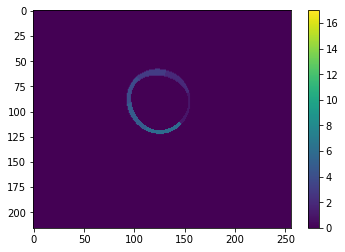

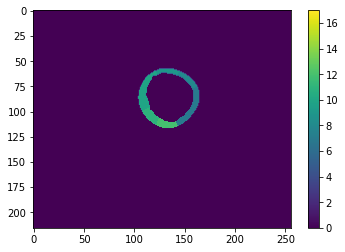

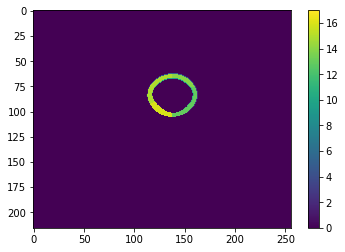

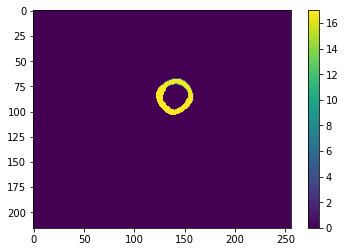

In [263]:
plt.figure()
plt.imshow(heart_aha17_4d[:, :, 5, dia_frame], vmin=0, vmax=17)
plt.colorbar()
plt.figure()
plt.imshow(heart_aha17_4d[:, :, 8, dia_frame], vmin=0, vmax=17)
plt.colorbar()
plt.figure()
plt.imshow(heart_aha17_4d[:, :, 10, dia_frame], vmin=0, vmax=17)
plt.colorbar()

plt.figure()
plt.imshow(heart_aha17_4d[:, :, 11, dia_frame], vmin=0, vmax=17)
plt.colorbar()